In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
cd "drive/MyDrive/rl"

[Errno 2] No such file or directory: 'drive/MyDrive/rl'
/content/drive/MyDrive/rl


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import gym
import pandas as pd
import numpy as np
import time
import itertools
import copy
import random
import csv

from replay_memory import NStepReplayMemory, LambdaReplayMemory, OmegaReplayMemory
import utils

In [21]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Configuring PyTorch for deterministic operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class FullyConnectedModel(nn.Module):
    """
    FullyConnectedModel is a neural network model with fully connected layers and ReLU activation functions.

    Parameters:
    input_size (int): The size of the input layer.
    output_size (int): The size of the output layer.
    """

    def __init__(self, input_size, output_size):
        """
        Initializes the FullyConnectedModel.

        Parameters:
        input_size (int): The size of the input layer.
        output_size (int): The size of the output layer.
        """
        super(FullyConnectedModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_size, 16)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(16, 16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 16)
        self.activation3 = nn.ReLU()
        self.output_layer = nn.Linear(16, output_size)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        """
        Defines the forward pass of the network.

        Parameters:
        inputs (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The output tensor after passing through the network.
        """
        x = self.flatten(inputs)
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_layer(x)
        return x

In [24]:
class DQN_Agent(object):
    """
    DQN_Agent is a deep Q-learning agent for reinforcement learning.

    Parameters:
    env (gym.Env): The environment in which the agent interacts.
    replay_memory (ReplayMemory): The replay memory to store experiences.
    architecture (nn.Module): The neural network architecture for the Q-network.
    optimizer (torch.optim.Optimizer): The optimizer for training the Q-network.
    exploration (Exploration): The exploration strategy for action selection.
    prepopulate (int): The number of steps to prepopulate the replay memory before training.
    target_update_freq (int): The frequency of target network updates.
    batch_size (int): The batch size for training.
    """

    def __init__(self, env, replay_memory, architecture, optimizer,
                 exploration, prepopulate, target_update_freq, batch_size):
        """
        Initializes the DQN_Agent.

        Parameters:
        env (gym.Env): The environment in which the agent interacts.
        replay_memory (ReplayMemory): The replay memory to store experiences.
        architecture (nn.Module): The neural network architecture for the Q-network.
        optimizer (torch.optim.Optimizer): The optimizer for training the Q-network.
        exploration (Exploration): The exploration strategy for action selection.
        prepopulate (int): The number of steps to prepopulate the replay memory before training.
        target_update_freq (int): The frequency of target network updates.
        batch_size (int): The batch size for training.
        """
        self.env = env
        self.input_shape = env.observation_space.shape[0]
        self.n_actions = env.action_space.n

        self.q_network = architecture(self.input_shape, self.n_actions).to(device)
        self.optimizer = optimizer(self.q_network.parameters())
        self.replay_memory = copy.deepcopy(replay_memory)
        self.replay_memory.register_refresh_func(self.refresh)

        self.exploration = exploration
        self.prepopulate = prepopulate
        self.target_update_freq = target_update_freq
        self.batch_size = batch_size
        self.t = 0

    def refresh(self, states_, actions_):
        """
        Refreshes the Q-values for the given states and actions.

        Parameters:
        states_ (list): List of states.
        actions_ (list): List of actions.

        Returns:
        tuple: Tuple containing greedy Q-values, mask, and on-policy Q-values.
        """
        assert len(states_) == len(actions_) + 1, "We should have an extra bootstrap state"
        states = torch.tensor(states_, dtype=torch.float32).to(device)
        actions = torch.tensor(actions_, dtype=torch.int64).to(device)

        with torch.no_grad():
            qvalues = self.q_network(states)
            greedy_qvals, greedy_acts = torch.max(qvalues, dim=1)
            onpolicy_qvals = qvalues[:-1].gather(1, actions.unsqueeze(1)).squeeze()
            mask = (actions == greedy_acts[:-1])

        return greedy_qvals.cpu().numpy(), mask.cpu().numpy(), onpolicy_qvals.cpu().numpy()

    def epsilon_greedy(self, state, epsilon=0):
        """
        Selects an action using an epsilon-greedy strategy.

        Parameters:
        state (np.ndarray): The current state.
        epsilon (float): The probability of selecting a random action.

        Returns:
        int: The selected action.
        """
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                qvalues = self.q_network(state_tensor)
            action = torch.argmax(qvalues, dim=1).item()
        return action

    def update(self, batch_size):
        """
        Updates the Q-network using a batch of experiences from the replay memory.

        Parameters:
        batch_size (int): The batch size for training.
        """
        state_batch_, action_batch_, return_batch_ = self.replay_memory.sample(batch_size)
        state_batch = torch.tensor(state_batch_, dtype=torch.float32).to(device)
        action_batch = torch.tensor(action_batch_, dtype=torch.int64).to(device)
        return_batch = torch.tensor(return_batch_, dtype=torch.float32).to(device)

        qvalues = self.q_network(state_batch)
        onpolicy_qvalues = qvalues.gather(1, action_batch.unsqueeze(1)).squeeze()

        td_error = return_batch - onpolicy_qvalues
        loss = F.mse_loss(onpolicy_qvalues, return_batch)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()

    def train(self):
        """
        Trains the DQN agent.
        """
        obs, _ = self.env.reset()
        terminated = False
        truncated = False
        while not (terminated or truncated):
            train_frac = 1.0
            epsilon = self.exploration.value(self.t)

            if self.t >= self.prepopulate:
                if self.t % self.target_update_freq == 0:
                    self.replay_memory.refresh(train_frac)
                    num_train_iterations = self.replay_memory.cache_size // self.batch_size
                    for _ in range(num_train_iterations):
                        self.update(self.batch_size)

            self.replay_memory.store_obs(obs)
            state = self.replay_memory.encode_recent_observation()
            action = self.epsilon_greedy(state, epsilon)
            obs, reward, terminated, truncated, _ = self.env.step(action)
            self.replay_memory.store_effect(action, reward, terminated or truncated)
            self.t += 1

    def test(self):
        """
        Tests the DQN agent.

        Returns:
        float: The total reward accumulated during the test.
        """
        state, _ = self.env.reset()
        rewards = []
        terminated = False
        truncated = False
        while not (terminated or truncated):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            action = torch.argmax(q_values, dim=1).item()
            state, reward, terminated, truncated, _ = self.env.step(action)
            rewards.append(reward)

        return np.sum(rewards)

In [25]:
# Function to create environment with seed
def make_env(env_name, seed):
    env = gym.make(env_name)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

In [41]:
def train_dqn(env_name, return_type, param_value, num_episodes_train=250, num_episodes_test=25, seed=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = make_env(env_name, seed)

    capacity = 50000
    history_len = 1
    discount = 0.99
    cache_size = 10000
    block_size = 100
    priority = 0.0

    if return_type == "omega":
        replay_memory = OmegaReplayMemory(capacity, history_len, discount, cache_size, block_size, priority, param_value)
    elif return_type == "lambda":
        replay_memory = LambdaReplayMemory(capacity, history_len, discount, cache_size, block_size, priority, param_value, use_watkins=True)
    elif return_type == "nstep":
        replay_memory = NStepReplayMemory(capacity, history_len, discount, cache_size, block_size, priority, param_value)
    else:
        raise ValueError("Invalid return type specified. Choose from 'omega', 'lambda', or 'nstep'.")

    architecture = FullyConnectedModel
    optimizer = optim.Adam
    prepopulate = 200
    exploration_schedule = utils.PiecewiseSchedule(
        [(0, 1.0), (prepopulate, 1.0), (prepopulate + 200, 0.1)],
        outside_value=0.1,
    )
    target_update_freq = 50
    batch_size = 32

    agent = DQN_Agent(env, replay_memory, architecture, optimizer,
                      exploration_schedule, prepopulate, target_update_freq, batch_size)

    reward_means = []
    reward_sds = []

    for m in range(num_episodes_train):
        agent.train()

        if m % 10 == 0:
            print(f"Episode: {m}")
            G = torch.zeros(num_episodes_test, device=device)
            for k in range(num_episodes_test):
                g = agent.test()
                G[k] = g
            reward_mean = G.mean().item()
            reward_sd = G.std().item()
            print(f"The test reward for episode {m} is {reward_mean} with a standard deviation of {reward_sd}.")
            reward_means.append(reward_mean)
            reward_sds.append(reward_sd)

    # Read or create results.csv
    results_file = f"{env_name}_results.csv"
    if os.path.exists(results_file):
        df = pd.read_csv(results_file)
    else:
        df = pd.DataFrame()

    # Add new columns with results
    column_mean_name = f"{return_type}_{param_value}_mean"
    column_sd_name = f"{return_type}_{param_value}_sd"
    df[column_mean_name] = reward_means
    df[column_sd_name] = reward_sds

    # Save the results back to CSV
    df.to_csv(results_file, index=False)

    return df

In [47]:
env_name = 'CartPole-v1'

print("----------OMEGA----------")
train_dqn(env_name, 'omega', 50)

----------OMEGA----------
Episode: 0
The test reward for episode 0 is 9.279999732971191 with a standard deviation of 0.737111508846283.
Episode: 10
The test reward for episode 10 is 25.399999618530273 with a standard deviation of 5.090841293334961.
Episode: 20
The test reward for episode 20 is 113.63999938964844 with a standard deviation of 6.156838893890381.
Episode: 30
The test reward for episode 30 is 179.0399932861328 with a standard deviation of 7.7646636962890625.
Episode: 40
The test reward for episode 40 is 249.1599884033203 with a standard deviation of 10.188556671142578.
Episode: 50
The test reward for episode 50 is 500.0 with a standard deviation of 0.0.
Episode: 60
The test reward for episode 60 is 500.0 with a standard deviation of 0.0.
Episode: 70
The test reward for episode 70 is 500.0 with a standard deviation of 0.0.
Episode: 80
The test reward for episode 80 is 500.0 with a standard deviation of 0.0.
Episode: 90
The test reward for episode 90 is 500.0 with a standard 

,omega_50_mean,omega_50_sd
0,9.280000,0.737112
1,25.400000,5.090841
2,113.639999,6.156839
3,179.039993,7.764664
4,249.159988,10.188557
5,500.000000,0.000000
6,500.000000,0.000000
7,500.000000,0.000000
8,500.000000,0.000000
9,500.000000,0.000000


In [49]:
print("----------NSTEP----------")
train_dqn(env_name, 'nstep', 1)

----------NSTEP----------
Episode: 0
The test reward for episode 0 is 9.279999732971191 with a standard deviation of 0.737111508846283.
Episode: 10
The test reward for episode 10 is 30.559999465942383 with a standard deviation of 3.958956003189087.
Episode: 20
The test reward for episode 20 is 71.0 with a standard deviation of 7.604823589324951.
Episode: 30
The test reward for episode 30 is 153.51998901367188 with a standard deviation of 11.034490585327148.
Episode: 40
The test reward for episode 40 is 139.0 with a standard deviation of 12.369317054748535.
Episode: 50
The test reward for episode 50 is 500.0 with a standard deviation of 0.0.
Episode: 60
The test reward for episode 60 is 113.04000091552734 with a standard deviation of 2.805946111679077.
Episode: 70
The test reward for episode 70 is 76.15999603271484 with a standard deviation of 2.6876254081726074.
Episode: 80
The test reward for episode 80 is 22.31999969482422 with a standard deviation of 3.7938547134399414.
Episode: 90


,omega_50_mean,omega_50_sd,nstep_1_mean,nstep_1_sd
0,9.280000,0.737112,9.280000,0.737112
1,25.400000,5.090841,30.559999,3.958956
2,113.639999,6.156839,71.000000,7.604824
3,179.039993,7.764664,153.519989,11.034491
4,249.159988,10.188557,139.000000,12.369317
5,500.000000,0.000000,500.000000,0.000000
6,500.000000,0.000000,113.040001,2.805946
7,500.000000,0.000000,76.159996,2.687625
8,500.000000,0.000000,22.320000,3.793855
9,500.000000,0.000000,81.559998,32.053448


In [53]:
print("----------NSTEP----------")
train_dqn(env_name, 'nstep', 3)

----------NSTEP----------
Episode: 0
The test reward for episode 0 is 9.279999732971191 with a standard deviation of 0.737111508846283.
Episode: 10
The test reward for episode 10 is 102.83999633789062 with a standard deviation of 6.374950885772705.
Episode: 20
The test reward for episode 20 is 466.0799865722656 with a standard deviation of 74.31123352050781.
Episode: 30
The test reward for episode 30 is 450.8800048828125 with a standard deviation of 58.48883056640625.
Episode: 40
The test reward for episode 40 is 408.1999816894531 with a standard deviation of 111.67623901367188.
Episode: 50
The test reward for episode 50 is 239.83999633789062 with a standard deviation of 81.2155990600586.
Episode: 60
The test reward for episode 60 is 500.0 with a standard deviation of 0.0.
Episode: 70
The test reward for episode 70 is 500.0 with a standard deviation of 0.0.
Episode: 80
The test reward for episode 80 is 500.0 with a standard deviation of 0.0.
Episode: 90
The test reward for episode 90 i

,omega_50_mean,omega_50_sd,nstep_1_mean,nstep_1_sd,lambda_0.5_mean,lambda_0.5_sd,nstep_3_mean,nstep_3_sd
0,9.280000,0.737112,9.280000,0.737112,9.599999,0.645497,9.280000,0.737112
1,25.400000,5.090841,30.559999,3.958956,11.960000,1.457166,102.839996,6.374951
2,113.639999,6.156839,71.000000,7.604824,203.879990,45.179569,466.079987,74.311234
3,179.039993,7.764664,153.519989,11.034491,230.399994,38.120422,450.880005,58.488831
4,249.159988,10.188557,139.000000,12.369317,441.039978,107.163223,408.199982,111.676239
5,500.000000,0.000000,500.000000,0.000000,128.959991,8.531705,239.839996,81.215599
6,500.000000,0.000000,113.040001,2.805946,132.440002,5.620498,500.000000,0.000000
7,500.000000,0.000000,76.159996,2.687625,154.239990,6.125630,500.000000,0.000000
8,500.000000,0.000000,22.320000,3.793855,500.000000,0.000000,500.000000,0.000000
9,500.000000,0.000000,81.559998,32.053448,172.440002,10.543877,500.000000,0.000000


In [50]:
print("----------LAMBDA----------")
train_dqn(env_name, 'lambda', 0.5)

----------LAMBDA----------
Episode: 0
The test reward for episode 0 is 9.59999942779541 with a standard deviation of 0.64549720287323.


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 10
The test reward for episode 10 is 11.960000038146973 with a standard deviation of 1.4571661949157715.
Episode: 20
The test reward for episode 20 is 203.87998962402344 with a standard deviation of 45.179569244384766.
Episode: 30
The test reward for episode 30 is 230.39999389648438 with a standard deviation of 38.12042236328125.
Episode: 40
The test reward for episode 40 is 441.03997802734375 with a standard deviation of 107.16322326660156.
Episode: 50
The test reward for episode 50 is 128.95999145507812 with a standard deviation of 8.531704902648926.
Episode: 60
The test reward for episode 60 is 132.44000244140625 with a standard deviation of 5.620497703552246.
Episode: 70
The test reward for episode 70 is 154.239990234375 with a standard deviation of 6.125629901885986.
Episode: 80
The test reward for episode 80 is 500.0 with a standard deviation of 0.0.
Episode: 90
The test reward for episode 90 is 172.44000244140625 with a standard deviation of 10.543876647949219.
Episode:

,omega_50_mean,omega_50_sd,nstep_1_mean,nstep_1_sd,lambda_0.5_mean,lambda_0.5_sd
0,9.280000,0.737112,9.280000,0.737112,9.599999,0.645497
1,25.400000,5.090841,30.559999,3.958956,11.960000,1.457166
2,113.639999,6.156839,71.000000,7.604824,203.879990,45.179569
3,179.039993,7.764664,153.519989,11.034491,230.399994,38.120422
4,249.159988,10.188557,139.000000,12.369317,441.039978,107.163223
5,500.000000,0.000000,500.000000,0.000000,128.959991,8.531705
6,500.000000,0.000000,113.040001,2.805946,132.440002,5.620498
7,500.000000,0.000000,76.159996,2.687625,154.239990,6.125630
8,500.000000,0.000000,22.320000,3.793855,500.000000,0.000000
9,500.000000,0.000000,81.559998,32.053448,172.440002,10.543877


In [79]:
env_name = 'Acrobot-v1'

print("----------OMEGA----------")
train_dqn(env_name, 'omega', 50)

----------OMEGA----------
Episode: 0
The test reward for episode 0 is -500.0 with a standard deviation of 0.0.
Episode: 10
The test reward for episode 10 is -195.47999572753906 with a standard deviation of 110.21725463867188.
Episode: 20
The test reward for episode 20 is -164.67999267578125 with a standard deviation of 110.45954132080078.
Episode: 30
The test reward for episode 30 is -110.63999938964844 with a standard deviation of 25.990188598632812.
Episode: 40
The test reward for episode 40 is -115.87999725341797 with a standard deviation of 23.51651954650879.
Episode: 50
The test reward for episode 50 is -102.39999389648438 with a standard deviation of 34.02082824707031.
Episode: 60
The test reward for episode 60 is -98.91999816894531 with a standard deviation of 19.691200256347656.
Episode: 70
The test reward for episode 70 is -104.95999908447266 with a standard deviation of 19.688152313232422.
Episode: 80
The test reward for episode 80 is -94.15999603271484 with a standard deviat

,omega_50_mean,omega_50_sd,nstep_1_mean,nstep_1_sd,lambda_0.5_mean,lambda_0.5_sd
0,-500.000000,0.000000,-500.000000,0.000000,-499.639984,1.800000
1,-195.479996,110.217255,-500.000000,0.000000,-133.199997,111.473839
2,-164.679993,110.459541,-99.519997,26.591227,-97.439995,29.904125
3,-110.639999,25.990189,-85.040001,15.303812,-88.479996,22.009695
4,-115.879997,23.516520,-87.559998,17.932930,-396.079987,172.250534
5,-102.399994,34.020828,-95.079994,20.643642,-88.040001,13.645757
6,-98.919998,19.691200,-87.159996,15.619646,-92.559998,37.740429
7,-104.959999,19.688152,-93.400002,15.386683,-92.519997,46.275551
8,-94.159996,14.025810,-89.360001,18.098988,-89.439995,23.439781
9,-87.320000,13.975335,-119.759995,82.336342,-82.080002,12.192621


In [58]:
print("----------NSTEP----------")
train_dqn(env_name, 'nstep', 1)

----------NSTEP----------


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0
The test reward for episode 0 is -500.0 with a standard deviation of 0.0.
Episode: 10
The test reward for episode 10 is -500.0 with a standard deviation of 0.0.
Episode: 20
The test reward for episode 20 is -99.5199966430664 with a standard deviation of 26.59122657775879.
Episode: 30
The test reward for episode 30 is -85.04000091552734 with a standard deviation of 15.303812026977539.
Episode: 40
The test reward for episode 40 is -87.55999755859375 with a standard deviation of 17.93292999267578.
Episode: 50
The test reward for episode 50 is -95.07999420166016 with a standard deviation of 20.64364242553711.
Episode: 60
The test reward for episode 60 is -87.15999603271484 with a standard deviation of 15.619646072387695.
Episode: 70
The test reward for episode 70 is -93.4000015258789 with a standard deviation of 15.386682510375977.
Episode: 80
The test reward for episode 80 is -89.36000061035156 with a standard deviation of 18.098987579345703.
Episode: 90
The test reward for epi

,omega_50_mean,omega_50_sd,nstep_1_mean,nstep_1_sd
0,-155.759995,47.083508,-500.000000,0.000000
1,-217.039993,184.388290,-500.000000,0.000000
2,-101.119995,84.527275,-99.519997,26.591227
3,-81.680000,12.068277,-85.040001,15.303812
4,-81.040001,12.644103,-87.559998,17.932930
5,-90.439995,28.555618,-95.079994,20.643642
6,-94.159996,32.327339,-87.159996,15.619646
7,-92.199997,14.162745,-93.400002,15.386683
8,-108.879997,82.724602,-89.360001,18.098988
9,-95.000000,18.255136,-119.759995,82.336342


In [ ]:
print("----------NSTEP----------")
train_dqn(env_name, 'nstep', 3)

In [59]:
print("----------LAMBDA----------")
train_dqn(env_name, 'lambda', 0.5)

----------LAMBDA----------


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0
The test reward for episode 0 is -499.6399841308594 with a standard deviation of 1.7999999523162842.
Episode: 10
The test reward for episode 10 is -133.1999969482422 with a standard deviation of 111.47383880615234.
Episode: 20
The test reward for episode 20 is -97.43999481201172 with a standard deviation of 29.904125213623047.
Episode: 30
The test reward for episode 30 is -88.47999572753906 with a standard deviation of 22.009695053100586.
Episode: 40
The test reward for episode 40 is -396.0799865722656 with a standard deviation of 172.2505340576172.
Episode: 50
The test reward for episode 50 is -88.04000091552734 with a standard deviation of 13.645756721496582.
Episode: 60
The test reward for episode 60 is -92.55999755859375 with a standard deviation of 37.74042892456055.
Episode: 70
The test reward for episode 70 is -92.5199966430664 with a standard deviation of 46.275550842285156.
Episode: 80
The test reward for episode 80 is -89.43999481201172 with a standard deviation of

,omega_50_mean,omega_50_sd,nstep_1_mean,nstep_1_sd,lambda_0.5_mean,lambda_0.5_sd
0,-155.759995,47.083508,-500.000000,0.000000,-499.639984,1.800000
1,-217.039993,184.388290,-500.000000,0.000000,-133.199997,111.473839
2,-101.119995,84.527275,-99.519997,26.591227,-97.439995,29.904125
3,-81.680000,12.068277,-85.040001,15.303812,-88.479996,22.009695
4,-81.040001,12.644103,-87.559998,17.932930,-396.079987,172.250534
5,-90.439995,28.555618,-95.079994,20.643642,-88.040001,13.645757
6,-94.159996,32.327339,-87.159996,15.619646,-92.559998,37.740429
7,-92.199997,14.162745,-93.400002,15.386683,-92.519997,46.275551
8,-108.879997,82.724602,-89.360001,18.098988,-89.439995,23.439781
9,-95.000000,18.255136,-119.759995,82.336342,-82.080002,12.192621


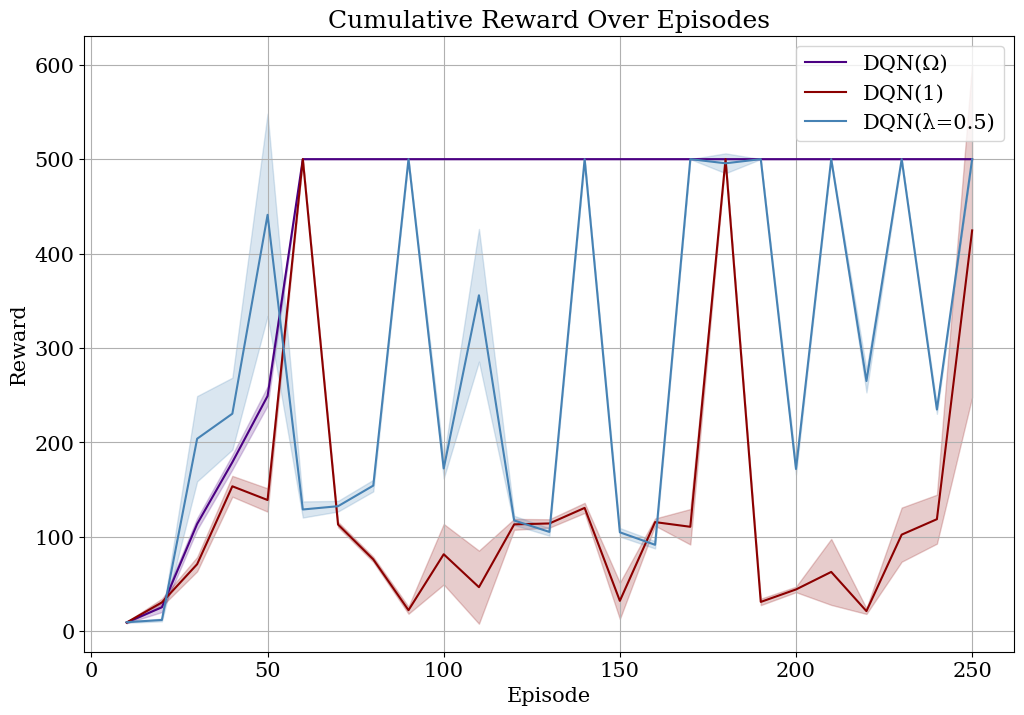

In [77]:
import matplotlib.pyplot as plt

# Read the CSV file into a dataframe
file_path = 'CartPole-v1_results.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Define labels for the columns
# Define labels for the columns
labels = {
    'omega_50_mean': 'DQN(Ω)',
    'nstep_1_mean': 'DQN(1)',
    'nstep_3_mean': 'DQN(3)',
    'lambda_0.5_mean': 'DQN(λ=0.5)'
}

# Set the figure size and color palette
plt.figure(figsize=(12, 8))
colors = ['#4B0082', '#8B0000', '#4682B4'] #, '#228B22'

# Plot each column with mean and shaded area for standard deviation
for i, col in enumerate(['omega_50_mean', 'nstep_1_mean', 'lambda_0.5_mean']): #, 'nstep_3_mean'
    mean_values = df[col]
    std_values = df[col.replace('mean', 'sd')]
    episodes = range(10, 10 * (len(df) + 1), 10)
    plt.plot(episodes, mean_values, label=labels[col], color=colors[i])
    plt.fill_between(episodes, mean_values - std_values, mean_values + std_values, color=colors[i], alpha=0.2)

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Cumulative Reward Over Episodes')
plt.legend()
plt.grid(True)

# Customize font
plt.rc('font', family='serif', size=15)

# Show the plot
plt.show()

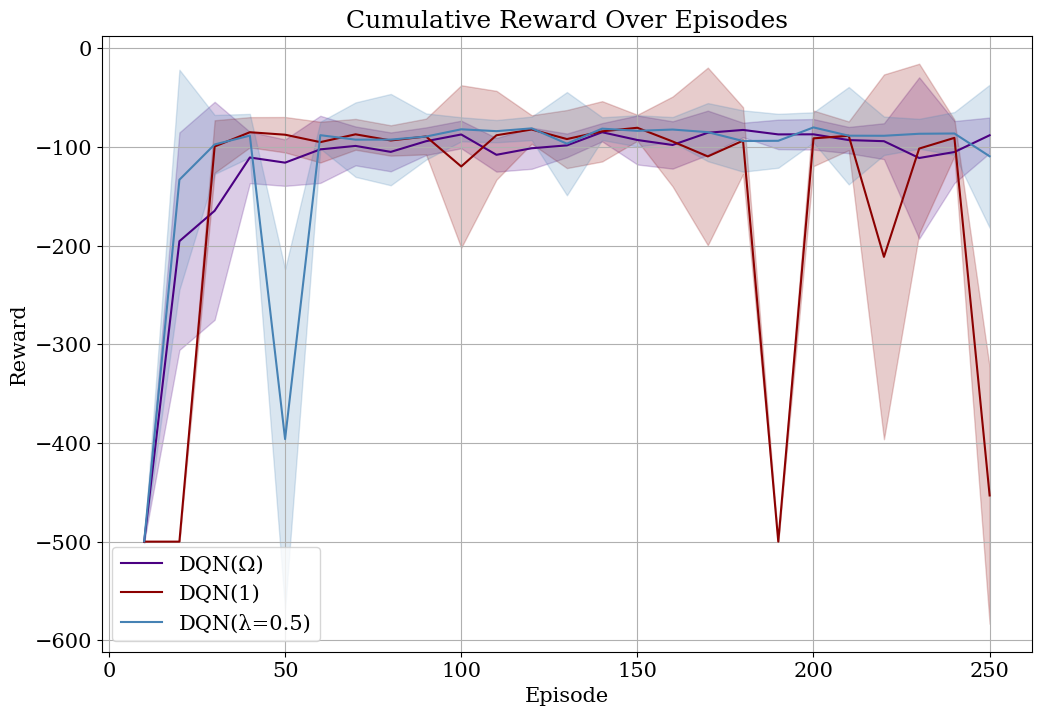

In [80]:
import matplotlib.pyplot as plt

# Read the CSV file into a dataframe
file_path = 'Acrobot-v1_results.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Define labels for the columns
# Define labels for the columns
labels = {
    'omega_50_mean': 'DQN(Ω)',
    'nstep_1_mean': 'DQN(1)',
    'nstep_3_mean': 'DQN(3)',
    'lambda_0.5_mean': 'DQN(λ=0.5)'
}

# Set the figure size and color palette
plt.figure(figsize=(12, 8))
colors = ['#4B0082', '#8B0000', '#4682B4'] #, '#228B22'

# Plot each column with mean and shaded area for standard deviation
for i, col in enumerate(['omega_50_mean', 'nstep_1_mean', 'lambda_0.5_mean']): #, 'nstep_3_mean'
    mean_values = df[col]
    std_values = df[col.replace('mean', 'sd')]
    episodes = range(10, 10 * (len(df) + 1), 10)
    plt.plot(episodes, mean_values, label=labels[col], color=colors[i])
    plt.fill_between(episodes, mean_values - std_values, mean_values + std_values, color=colors[i], alpha=0.2)

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Cumulative Reward Over Episodes')
plt.legend()
plt.grid(True)

# Customize font
plt.rc('font', family='serif', size=15)

# Show the plot
plt.show()